# Using enterprise to analyze PTA data

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,
* How to setup an analysis of individual pulsar noise properties,
* How to post-process your results.

If you are interested in working through this notebook, but do not want to install the software, we have prepared a related Google Colab notebook: https://colab.research.google.com/drive/1xft6F9nyoEHUVn1LbW-0qgXiiKDJuR3X#scrollTo=7kVh83a8w36s

By copying this notebook, you can install the software to your own Google Colab account and run the software without installation on your computer.

# Load modules

In [1]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.

In [3]:
# some pathing to get to the data folder (this won't work if you change the parent folder name)
foldername = os.path.basename(os.getcwd())
if foldername != '12p5yr_stochastic_analysis':
    os.chdir(os.path.pardir)
datadir = os.path.join(os.getcwd(), 'data') # set your data directory
print(datadir)

/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data


In [43]:
psrstring = 'J1909-3744'  # name of the pulsar

parfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'par'), psrstring + '*')))
timfiles = sorted(glob.glob(os.path.join(os.path.join(datadir, 'tim'), psrstring + '*')))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [11]:
print(parfiles)
print(timfiles)

['/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data/par/J1909-3744_NANOGrav_12yv3.gls.par']
['/Users/aaronjohnson/Documents/GitHub/12p5yr_stochastic_analysis/data/tim/J1909-3744_NANOGrav_12yv3.tim']


## Load into Pulsar class list

* The `enterprise` Pulsar class uses `libstempo` to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.
* You can also explicitly set the clock file to a version of `BIPM`, e.g. `BIPM(2018)`. This is less important, and you can let the code take the value from the `par` file.
* When you execute the following cell, you will get warnings like `WARNING: Could not find pulsar distance for PSR ...`. Don't worry! This is expected, and fine. Not all pulsars have well constrained distances, and will be set to `1 kpc` with a `20%` uncertainty.

### Read par and tim files into enterprise Pulsar objects

In [15]:
psrs = []
for p, t in zip(parfiles, timfiles):
    if psrstring in p:
        psr = Pulsar(p, t, ephem='DE438', clk='BIPM(2018)')
        psrs.append(psr)

In [17]:
## Get parameter noise dictionary
noise_ng12 = os.path.join(datadir, 'channelized_12p5yr_v3_full_noisedict.json')

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

In [18]:
## Load in empirical distributions
#emp_dists = pickle.load(open(datadir + '12yr_emp_dist_RNonly_py3.pkl', 'rb'))
#emp_dists = '/home/stephen.taylor/NANOGrav/nanograv_12p5yr_analysis/nanograv_12p5yr_analysis_mar2020/data/12yr_emp_dist_RNonly_py3.pkl'

# Single pulsar analysis

* `enterprise` is structured so that one first creates `parameters`, then `signals` that these `parameters` belong to, then finally a `model` that is the union of all `signals` and the `data`.

* We will show this explciitly below, then introduce some model shortcut code that will make your life easier.
* We test on `J1909`.

In [19]:
psr = [p for p in psrs if p.name == 'J1909-3744'][0]

In [23]:
# find the maximum time span to set red-noise/DM-variation frequency sampling
tmin = psr.toas.min()
tmax = psr.toas.max()
Tspan = np.max(tmax) - np.min(tmin)

In [25]:
# define selection by observing backend
# there will be separate white noise parameters for each observing backend
# since NANOGrav began taking data, there have been two generations of backends
# (ASP and PUPPI at Arecibo, GASP and GUPPI at Green Bank)
selection = selections.Selection(selections.by_backend)

## Create parameters

* White noise parameters are varied for each pulsar, and then set to their most likely values when running the analysis for the entire array.

In [26]:
# white noise parameters
white_vary = True
if white_vary:
    efac = parameter.Uniform(0.01, 10.0)
    equad = parameter.Uniform(-8.5, -5)
    ecorr = parameter.Uniform(-8.5, -5)
else:
    efac = parameter.Constant() 
    equad = parameter.Constant() 
    ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

### [NOTE] If fixing white-noise, simply use the previously loaded params dictionary

## Create signals

In [28]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# timing model
tm = gp_signals.TimingModel(use_svd=True) # stabilizing timing model design matrix with SVD

## Piece the full model together

In [29]:
# full model
s = ef + eq + ec + rn + tm

In [30]:
# intialize a single-pulsar pta model
# see how the "model" acts on the "pulsar" object...
pta = signal_base.PTA(s(psr))

In [31]:
# [Optional] Set white-noise parmeters from previous analysis
pta.set_default_params(params)

In [32]:
len(pta.params)  # the higher this number is, the longer the model will take to sample

14

## Draw initial sample from model parameter space

In [33]:
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [34]:
ndim

14

## Setup sampler (simple, with no tricks)

In [35]:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) # helps to tune MCMC proposal distribution

# where chains will be written to
outdir = './chains_singlepsr_test_{}/'.format(str(psr.name))

# sampler object
sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outdir, 
                 resume=False)

## Sample the parameter space

This will take a while! Note that the normal runs typically use 1e6 to 5e6 samples. For the sake of finishing the sampling process more quickly, we use considerably fewer for this tutorial. The sampling process can be interrupted and resumed by changing to `resume=True` in the above cell.

In [85]:
# sampler for N steps
N = int(3e4)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

Finished 1.00 percent in 1784.804902 s Acceptance rate = 0.2094Adding DE jump with weight 50
Finished 1.10 percent in 1950.974649 s Acceptance rate = 0.214

KeyboardInterrupt: 

## Simple post-processing

In [86]:
list(pta.param_names)

['J1909-3744_Rcvr1_2_GASP_efac',
 'J1909-3744_Rcvr1_2_GASP_log10_ecorr',
 'J1909-3744_Rcvr1_2_GASP_log10_equad',
 'J1909-3744_Rcvr1_2_GUPPI_efac',
 'J1909-3744_Rcvr1_2_GUPPI_log10_ecorr',
 'J1909-3744_Rcvr1_2_GUPPI_log10_equad',
 'J1909-3744_Rcvr_800_GASP_efac',
 'J1909-3744_Rcvr_800_GASP_log10_ecorr',
 'J1909-3744_Rcvr_800_GASP_log10_equad',
 'J1909-3744_Rcvr_800_GUPPI_efac',
 'J1909-3744_Rcvr_800_GUPPI_log10_ecorr',
 'J1909-3744_Rcvr_800_GUPPI_log10_equad',
 'J1909-3744_red_noise_gamma',
 'J1909-3744_red_noise_log10_A']

In [87]:
chain = np.loadtxt(outdir + 'chain_1.txt')
burn = int(0.25 * chain.shape[0]) # experiment with burn-in

In [88]:
# Find column of chain file corresponding to a parameter
ind = list(pta.param_names).index(psrstring + '_red_noise_log10_A')

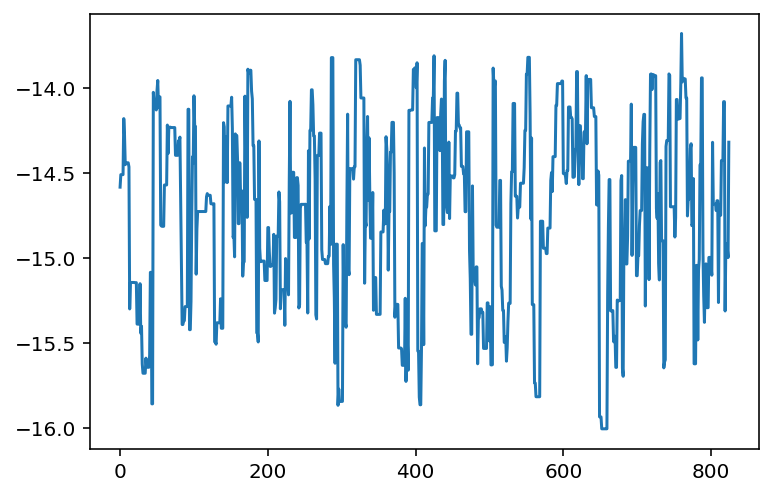

In [89]:
# Make trace-plot to diagnose sampling
plt.plot(chain[burn:, ind])

These chains are pretty clearly undersampled, but for the sake of showing the process, they should be sufficient.

Text(0, 0.5, 'PDF')

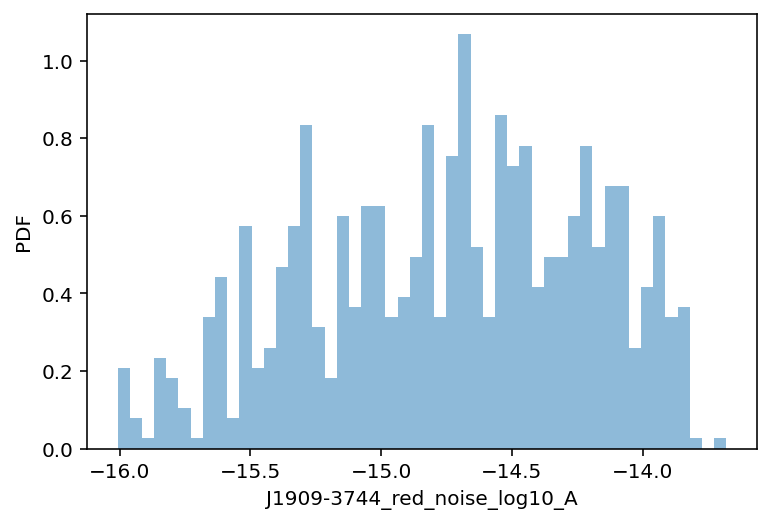

In [90]:
# Plot a histogram of the marginalized posterior distribution
plt.hist(chain[burn:,ind], 50, density=True, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5);
plt.xlabel(psrstring + '_red_noise_log10_A')
plt.ylabel('PDF')

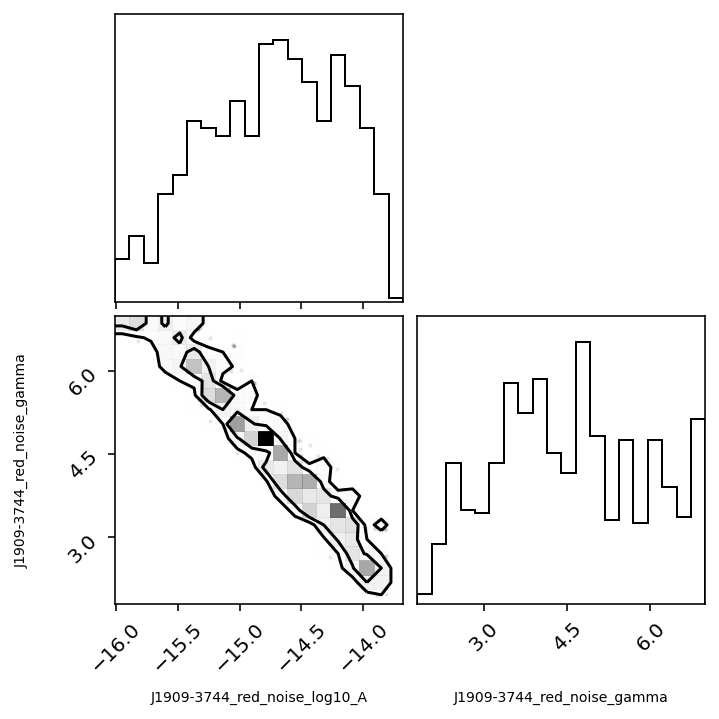

In [98]:
# Make 2d histogram plot for red noise
ind_redA = list(pta.param_names).index(psrstring + '_red_noise_log10_A')
ind_redgam = list(pta.param_names).index(psrstring + '_red_noise_gamma')
fig = corner.corner(chain[burn:, [ind_redA, ind_redgam]], 
                    labels=[psrstring + '_red_noise_log10_A', psrstring + '_red_noise_gamma'], label_kwargs={"fontsize": 7},
                   levels=[0.68,0.95]);

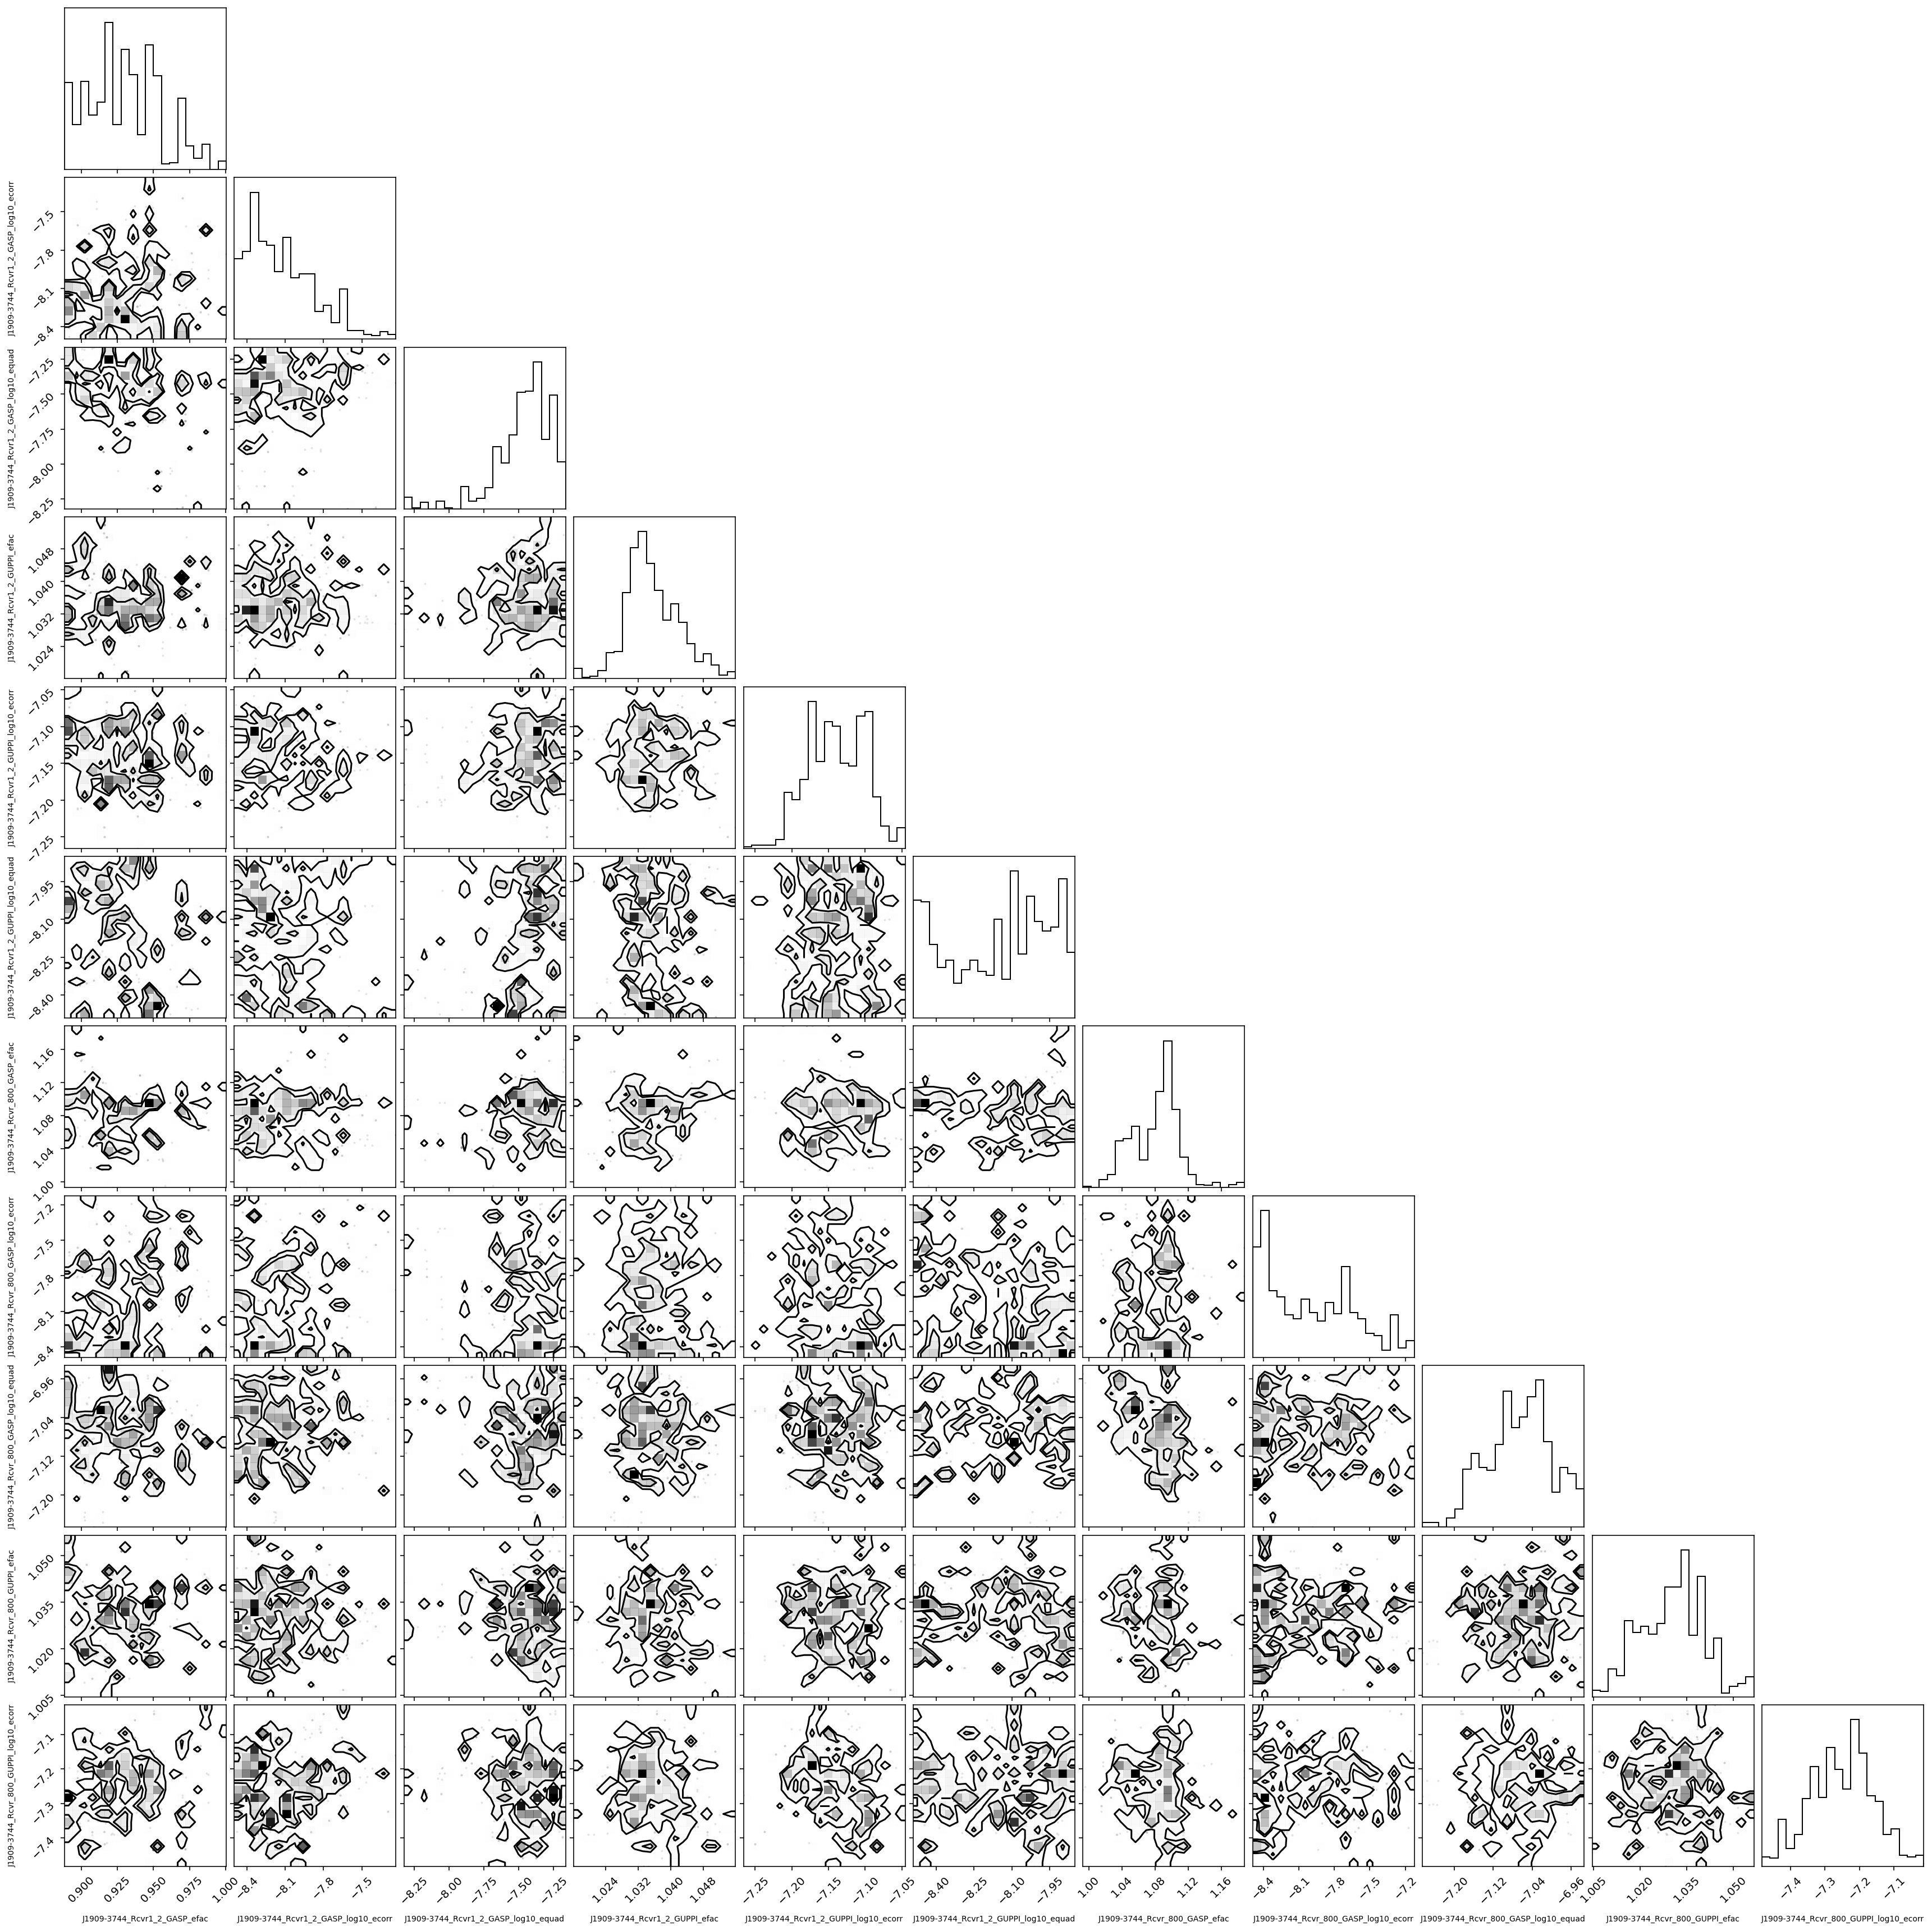

In [99]:
# Make 2d histogram plot for white noise
ind_end = list(pta.param_names).index(psrstring + '_Rcvr_800_GUPPI_log10_equad')
fig = corner.corner(chain[burn:, np.arange(ind_end)],
                    labels=list(pta.param_names[0:ind_end]), label_kwargs={"fontsize": 7},
                    levels=[0.68,0.95]);

## Now, the easy way to do all of this

Many of us have created shortcuts to carry out these tasks. You will find them in `enterprise_extensions`: https://github.com/nanograv/enterprise_extensions. Note that if you decide to do it this way on your own, you will still need the imported packages above. Setting the data directory and creating the `Pulsar` object is also required.

In [62]:
import enterprise_extensions
from enterprise_extensions import models, sampler

In [56]:
# Create a single pulsar model
pta = models.model_singlepsr_noise(psr, red_var=True, psd='powerlaw', 
                                   noisedict=None, white_vary=True, 
                                   tm_svd=True, components=30)

In [60]:
len(pta.params)
pta.params

[J1909-3744_Rcvr1_2_GASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1909-3744_Rcvr1_2_GASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr1_2_GASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr1_2_GUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1909-3744_Rcvr1_2_GUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr1_2_GUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr_800_GASP_efac:Uniform(pmin=0.01, pmax=10.0),
 J1909-3744_Rcvr_800_GASP_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr_800_GASP_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr_800_GUPPI_efac:Uniform(pmin=0.01, pmax=10.0),
 J1909-3744_Rcvr_800_GUPPI_log10_ecorr:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_Rcvr_800_GUPPI_log10_equad:Uniform(pmin=-8.5, pmax=-5),
 J1909-3744_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1909-3744_red_noise_log10_A:Uniform(pmin=-20, pmax=-11)]

In [63]:
# Setup a sampler instance.
# This will add some fanicer stuff than before, like prior draws, 
# and custom sample groupings.
sampler = sampler.setup_sampler(pta, outdir=outdir, resume=False)

Adding red noise prior draws...



In [64]:
# sampler for N steps
N = int(3e4)
x0 = np.hstack(p.sample() for p in pta.params)

# SCAM = Single Component Adaptive Metropolis
# AM = Adaptive Metropolis
# DE = Differential Evolution
## You can keep all these set at default values
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

KeyboardInterrupt: 

In [65]:
chain = np.loadtxt(outdir + '/chain_1.txt')
burn = int(0.25*chain.shape[0])

This covers the basic noise analysis for a single pulsar. Next, we move on to the Bayesian analysis of the common red noise process. In the common red noise process analysis we will fix the white noise parameters to their most likely values according to the single pulsar white noise runs as performed above. These values have been tabulated in the `/12p5yr_stochastic_analysis/data/channelized_12p5yr_v3_full_noisedict.json` file for the entire PTA.